In [1]:
pip install tensorflow-gpu==1.15.0

     |████████████████████████████████| 411.5MB 43kB/s 
     |████████████████████████████████| 3.8MB 38.1MB/s 
     |████████████████████████████████| 512kB 19.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=ce7e21defbffdc66ecf331f541aa87b547d37221f19504ac3e4058bf5e71f19e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np

from keras import initializers
from keras.datasets import cifar10, mnist
from keras.initializers import RandomNormal
from keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose, Dense,
                          Dropout, Flatten, Input, Reshape, UpSampling2D,
                          ZeroPadding2D)
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam

%matplotlib inline

Using TensorFlow backend.


In [15]:
# Consistent results
np.random.seed(10)

# The dimension of z (random noise vector)
noise_dim = 100

batch_size = 16
steps_per_epoch = 3750 # 60000/16
epochs = 201

# saving image in the folder
save_path = 'fcgan-images'

# dimensions of mnist data
img_rows, img_cols, channels = 28, 28, 1

# define lr, and beta_1 of Adam optimizer
optimizer = Adam(0.0002, 0.5)

In [4]:
# Create path for saving images
if save_path != None and not os.path.isdir(save_path):
    os.mkdir(save_path)

In [16]:
# Load and pre-process MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize to between -1 and 1
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

x_train = x_train.reshape(-1, img_rows*img_cols*channels)

In [17]:
def create_generator():
    generator = Sequential()
    
    # input as noise
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    # output as image
    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [18]:
def create_discriminator():
    discriminator = Sequential()
     
    # input is generator's image
    discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))
    # 0.3 dropout

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    # 0.3 dropout

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    # 0.3 dropout

    # output is whether this is required image or not
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [19]:
# create discriminator model
discriminator = create_discriminator()
print('DISCRIMINATOR SUMMARY')
discriminator.summary()

# create generator model
generator = create_generator()
print('GENERATOR SUMMARY')
generator.summary()

# Link the two models to create the GAN
gan = Sequential()
# add generator model
gan.add(generator)
# Make the discriminator untrainable when we are training the generator.  
# This doesn't effect the discriminator by itself
discriminator.trainable = False
gan.add(discriminator)

gan.compile(loss='binary_crossentropy', optimizer=optimizer)

print('GAN SUMMARY')
gan.summary()

DISCRIMINATOR SUMMARY
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (No

In [20]:
# Display images, and save them if the epoch number is specified
def show_images(noise, epoch=None):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    
    if epoch != None and save_path != None:
        plt.savefig(f'{save_path}/gan-images_epoch-{epoch}.png')
    plt.show()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0/201 	 Discriminator Loss: 0.6339724659919739 		 Generator Loss: 2.32753324508667


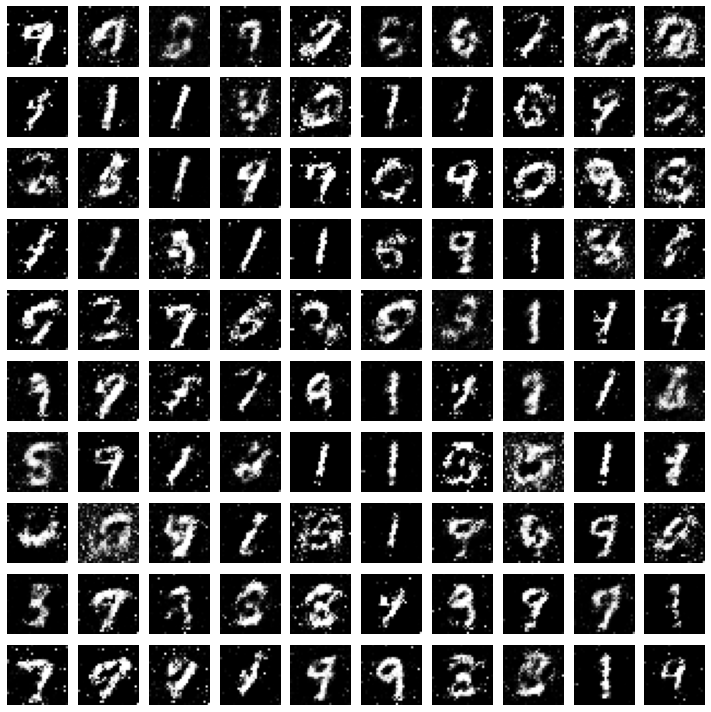

Epoch: 1/201 	 Discriminator Loss: 0.5586874485015869 		 Generator Loss: 1.4911799430847168
Epoch: 2/201 	 Discriminator Loss: 0.545081377029419 		 Generator Loss: 1.3320643901824951
Epoch: 3/201 	 Discriminator Loss: 0.5211838483810425 		 Generator Loss: 1.652298927307129
Epoch: 4/201 	 Discriminator Loss: 0.5468980073928833 		 Generator Loss: 1.4159777164459229
Epoch: 5/201 	 Discriminator Loss: 0.580399215221405 		 Generator Loss: 1.5717065334320068
Epoch: 6/201 	 Discriminator Loss: 0.4907953441143036 		 Generator Loss: 1.6359946727752686
Epoch: 7/201 	 Discriminator Loss: 0.5988831520080566 		 Generator Loss: 1.4571568965911865
Epoch: 8/201 	 Discriminator Loss: 0.6278445720672607 		 Generator Loss: 1.3230314254760742
Epoch: 9/201 	 Discriminator Loss: 0.526045024394989 		 Generator Loss: 1.667738914489746
Epoch: 10/201 	 Discriminator Loss: 0.49847590923309326 		 Generator Loss: 1.6583410501480103
Epoch: 11/201 	 Discriminator Loss: 0.6399002075195312 		 Generator Loss: 1.3567931

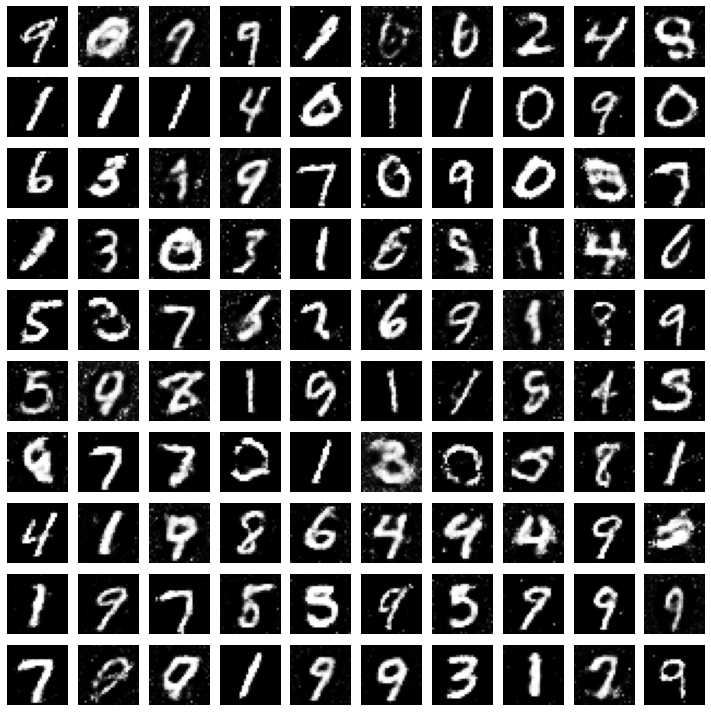

Epoch: 26/201 	 Discriminator Loss: 0.4879002571105957 		 Generator Loss: 1.8560104370117188
Epoch: 27/201 	 Discriminator Loss: 0.4594331383705139 		 Generator Loss: 1.605497121810913
Epoch: 28/201 	 Discriminator Loss: 0.5033137202262878 		 Generator Loss: 1.5051743984222412
Epoch: 29/201 	 Discriminator Loss: 0.5418108701705933 		 Generator Loss: 1.7122714519500732
Epoch: 30/201 	 Discriminator Loss: 0.47090944647789 		 Generator Loss: 1.6957658529281616
Epoch: 31/201 	 Discriminator Loss: 0.45625433325767517 		 Generator Loss: 1.8391375541687012
Epoch: 32/201 	 Discriminator Loss: 0.5900818705558777 		 Generator Loss: 1.44785737991333
Epoch: 33/201 	 Discriminator Loss: 0.6068578958511353 		 Generator Loss: 1.4393659830093384
Epoch: 34/201 	 Discriminator Loss: 0.5068936347961426 		 Generator Loss: 1.9993491172790527
Epoch: 35/201 	 Discriminator Loss: 0.5118852257728577 		 Generator Loss: 1.9220097064971924
Epoch: 36/201 	 Discriminator Loss: 0.6787631511688232 		 Generator Loss: 

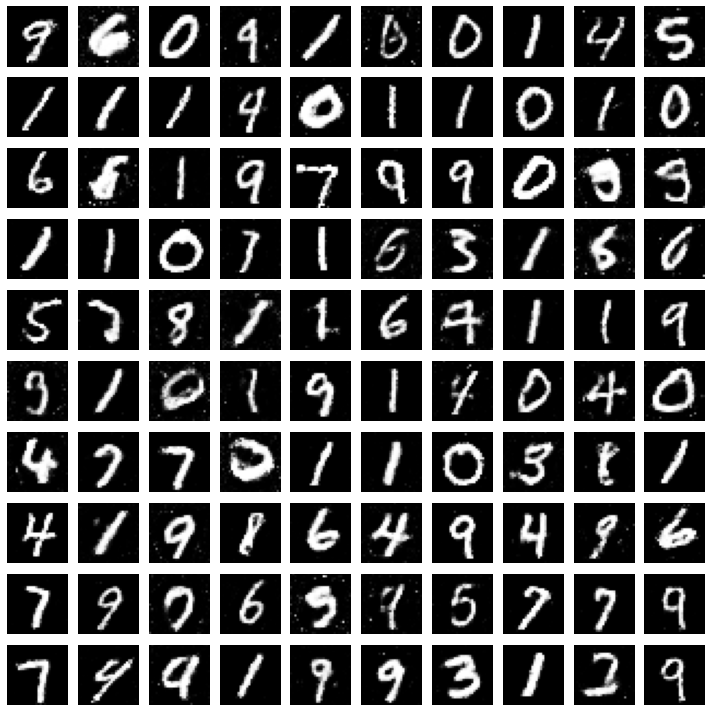

Epoch: 51/201 	 Discriminator Loss: 0.5347903966903687 		 Generator Loss: 1.6012965440750122
Epoch: 52/201 	 Discriminator Loss: 0.5136604309082031 		 Generator Loss: 1.9150973558425903
Epoch: 53/201 	 Discriminator Loss: 0.5231332778930664 		 Generator Loss: 1.6562669277191162
Epoch: 54/201 	 Discriminator Loss: 0.49512481689453125 		 Generator Loss: 1.7279202938079834
Epoch: 55/201 	 Discriminator Loss: 0.6222044825553894 		 Generator Loss: 1.7743420600891113
Epoch: 56/201 	 Discriminator Loss: 0.4810028672218323 		 Generator Loss: 1.7032606601715088
Epoch: 57/201 	 Discriminator Loss: 0.6143991947174072 		 Generator Loss: 1.77803635597229
Epoch: 58/201 	 Discriminator Loss: 0.5335652232170105 		 Generator Loss: 1.8671611547470093
Epoch: 59/201 	 Discriminator Loss: 0.6106795072555542 		 Generator Loss: 1.6873111724853516
Epoch: 60/201 	 Discriminator Loss: 0.4941108822822571 		 Generator Loss: 1.9943995475769043
Epoch: 61/201 	 Discriminator Loss: 0.47080475091934204 		 Generator Lo

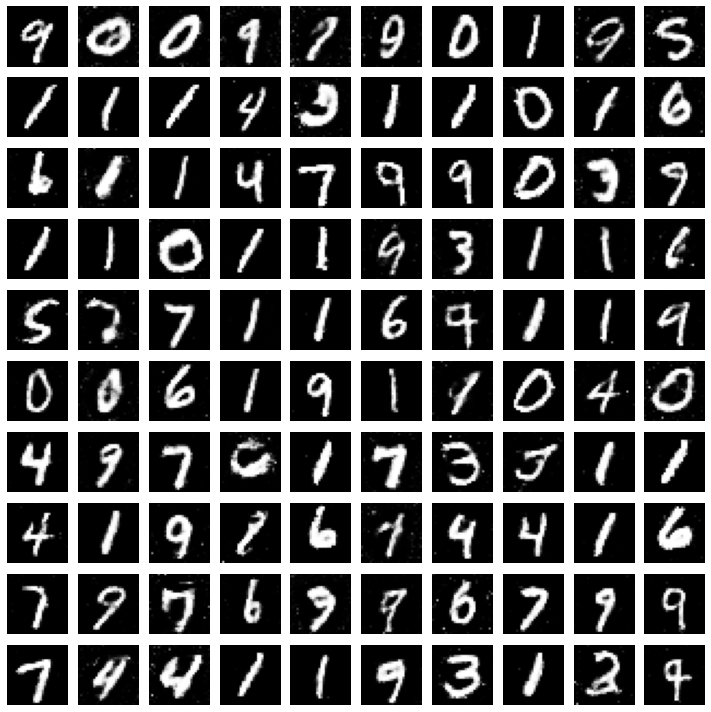

Epoch: 76/201 	 Discriminator Loss: 0.449825644493103 		 Generator Loss: 1.8918507099151611
Epoch: 77/201 	 Discriminator Loss: 0.515500009059906 		 Generator Loss: 1.911636471748352
Epoch: 78/201 	 Discriminator Loss: 0.4420565962791443 		 Generator Loss: 1.9164438247680664
Epoch: 79/201 	 Discriminator Loss: 0.4391127824783325 		 Generator Loss: 2.2496376037597656
Epoch: 80/201 	 Discriminator Loss: 0.4140608310699463 		 Generator Loss: 2.2208001613616943
Epoch: 81/201 	 Discriminator Loss: 0.39332452416419983 		 Generator Loss: 2.2875466346740723
Epoch: 82/201 	 Discriminator Loss: 0.5742831230163574 		 Generator Loss: 2.137310028076172
Epoch: 83/201 	 Discriminator Loss: 0.4386630058288574 		 Generator Loss: 2.1338138580322266
Epoch: 84/201 	 Discriminator Loss: 0.4477505087852478 		 Generator Loss: 2.1137261390686035
Epoch: 85/201 	 Discriminator Loss: 0.5772205591201782 		 Generator Loss: 2.063375949859619
Epoch: 86/201 	 Discriminator Loss: 0.36220160126686096 		 Generator Loss:

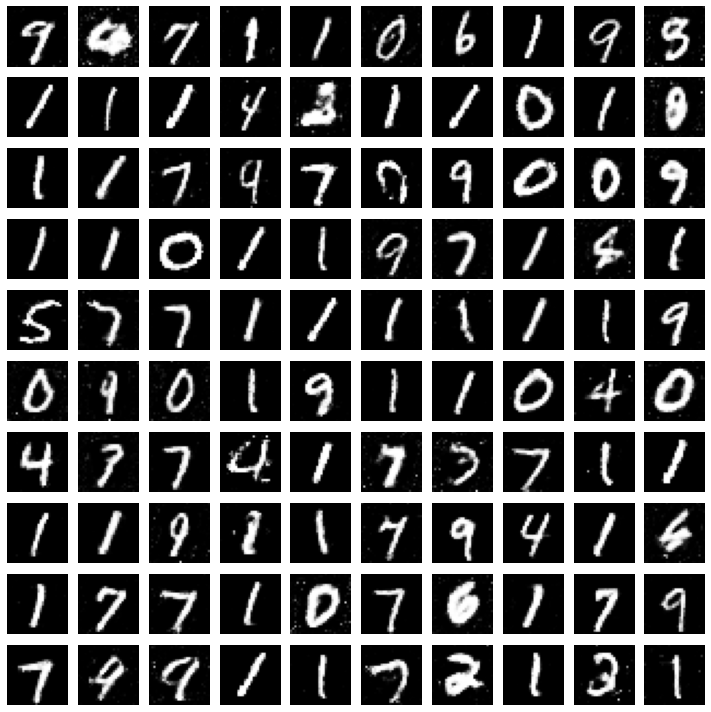

Epoch: 101/201 	 Discriminator Loss: 0.5175591707229614 		 Generator Loss: 1.7549434900283813
Epoch: 102/201 	 Discriminator Loss: 0.3887645900249481 		 Generator Loss: 2.40720272064209
Epoch: 103/201 	 Discriminator Loss: 0.4030662775039673 		 Generator Loss: 2.5019214153289795
Epoch: 104/201 	 Discriminator Loss: 0.46854501962661743 		 Generator Loss: 2.3728184700012207
Epoch: 105/201 	 Discriminator Loss: 0.4752058982849121 		 Generator Loss: 2.319349765777588
Epoch: 106/201 	 Discriminator Loss: 0.4343748092651367 		 Generator Loss: 2.005241870880127
Epoch: 107/201 	 Discriminator Loss: 0.4653593897819519 		 Generator Loss: 2.320352792739868
Epoch: 108/201 	 Discriminator Loss: 0.3545323610305786 		 Generator Loss: 2.5693960189819336
Epoch: 109/201 	 Discriminator Loss: 0.4186784625053406 		 Generator Loss: 2.7131171226501465
Epoch: 110/201 	 Discriminator Loss: 0.35103195905685425 		 Generator Loss: 2.5235273838043213
Epoch: 111/201 	 Discriminator Loss: 0.5338073372840881 		 Gene

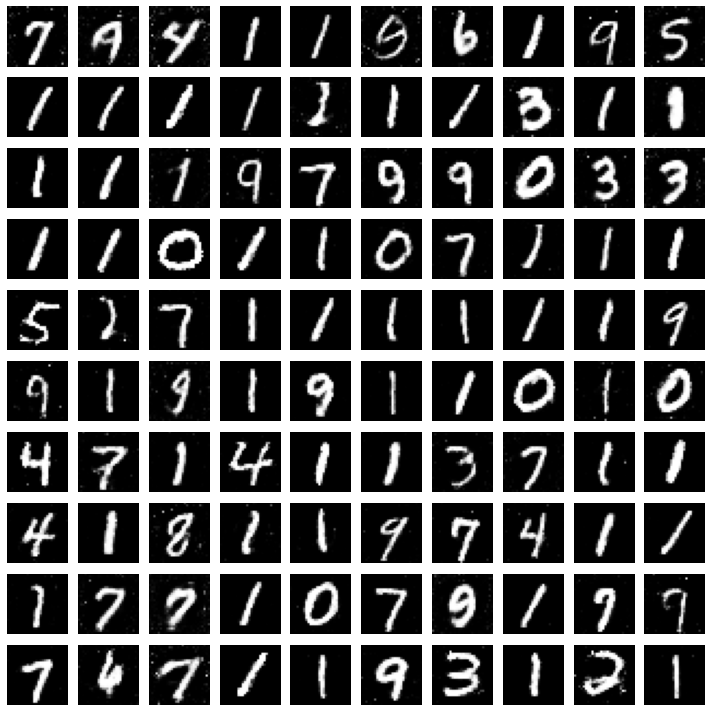

Epoch: 126/201 	 Discriminator Loss: 0.4656974673271179 		 Generator Loss: 2.3365845680236816
Epoch: 127/201 	 Discriminator Loss: 0.35140445828437805 		 Generator Loss: 2.02199125289917
Epoch: 128/201 	 Discriminator Loss: 0.4323512613773346 		 Generator Loss: 2.49790620803833
Epoch: 129/201 	 Discriminator Loss: 0.38333845138549805 		 Generator Loss: 2.439173936843872
Epoch: 130/201 	 Discriminator Loss: 0.4892147183418274 		 Generator Loss: 2.2730185985565186
Epoch: 131/201 	 Discriminator Loss: 0.3669426441192627 		 Generator Loss: 2.5423903465270996
Epoch: 132/201 	 Discriminator Loss: 0.3332858979701996 		 Generator Loss: 2.5003743171691895
Epoch: 133/201 	 Discriminator Loss: 0.4084976315498352 		 Generator Loss: 2.6569385528564453
Epoch: 134/201 	 Discriminator Loss: 0.43339118361473083 		 Generator Loss: 2.5789413452148438
Epoch: 135/201 	 Discriminator Loss: 0.30765995383262634 		 Generator Loss: 2.8636927604675293
Epoch: 136/201 	 Discriminator Loss: 0.4587414860725403 		 Ge

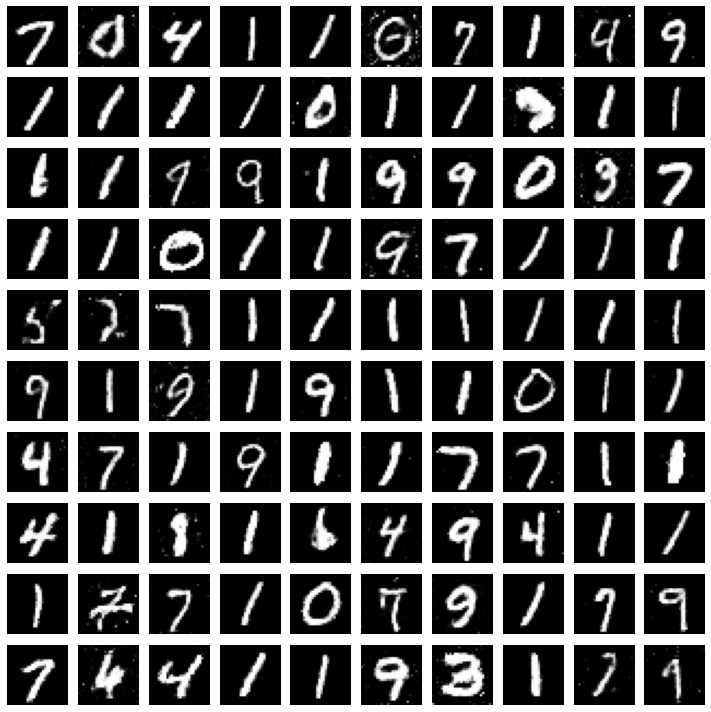

Epoch: 151/201 	 Discriminator Loss: 0.40326935052871704 		 Generator Loss: 3.15291690826416
Epoch: 152/201 	 Discriminator Loss: 0.32339608669281006 		 Generator Loss: 3.228574275970459
Epoch: 153/201 	 Discriminator Loss: 0.5112836360931396 		 Generator Loss: 2.233159065246582
Epoch: 154/201 	 Discriminator Loss: 0.3881226181983948 		 Generator Loss: 2.238142490386963
Epoch: 155/201 	 Discriminator Loss: 0.4452642798423767 		 Generator Loss: 2.4416024684906006
Epoch: 156/201 	 Discriminator Loss: 0.4150051474571228 		 Generator Loss: 2.0571298599243164
Epoch: 157/201 	 Discriminator Loss: 0.39316052198410034 		 Generator Loss: 2.522947311401367
Epoch: 158/201 	 Discriminator Loss: 0.37439045310020447 		 Generator Loss: 2.7310004234313965
Epoch: 159/201 	 Discriminator Loss: 0.3341238498687744 		 Generator Loss: 2.8238720893859863
Epoch: 160/201 	 Discriminator Loss: 0.4025060832500458 		 Generator Loss: 2.3106307983398438
Epoch: 161/201 	 Discriminator Loss: 0.4686421751976013 		 Gen

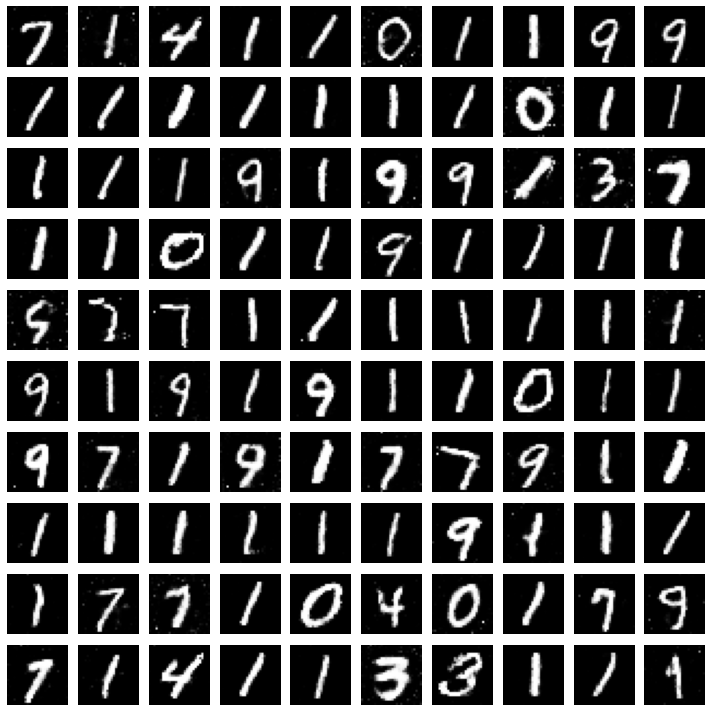

Epoch: 176/201 	 Discriminator Loss: 0.4156442880630493 		 Generator Loss: 2.625749111175537
Epoch: 177/201 	 Discriminator Loss: 0.389618843793869 		 Generator Loss: 2.445122718811035
Epoch: 178/201 	 Discriminator Loss: 0.3767656981945038 		 Generator Loss: 3.1850624084472656
Epoch: 179/201 	 Discriminator Loss: 0.3430902361869812 		 Generator Loss: 2.3870937824249268
Epoch: 180/201 	 Discriminator Loss: 0.4028823673725128 		 Generator Loss: 3.3140265941619873
Epoch: 181/201 	 Discriminator Loss: 0.3681655526161194 		 Generator Loss: 2.8963189125061035
Epoch: 182/201 	 Discriminator Loss: 0.4359321594238281 		 Generator Loss: 2.7185568809509277
Epoch: 183/201 	 Discriminator Loss: 0.33216965198516846 		 Generator Loss: 2.662022352218628
Epoch: 184/201 	 Discriminator Loss: 0.34564006328582764 		 Generator Loss: 3.0220413208007812
Epoch: 185/201 	 Discriminator Loss: 0.25087565183639526 		 Generator Loss: 2.513918161392212
Epoch: 186/201 	 Discriminator Loss: 0.5217296481132507 		 Gen

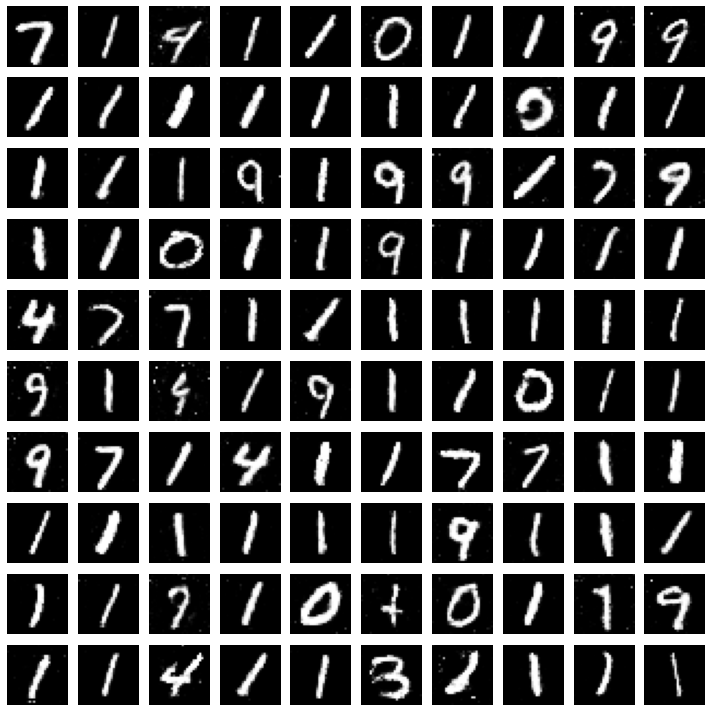

In [21]:
# Constant noise for viewing how the GAN progresses
static_noise = np.random.normal(0, 1, size=(100, noise_dim))

disc_loss = []
gen_loss = []

# Training loop
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        # generate noise/x train data for gan/generator
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        # fetch real data
        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        # generate fake data
        fake_x = generator.predict(noise)

        # combine fake and real data to generate x_train values for discriminator
        x = np.concatenate((real_x, fake_x))

        # generate y_train for discriminator by setting 0.9 for real data and 0 for fake data
        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        # train discriminator
        d_loss = discriminator.train_on_batch(x, disc_y)

        # generate y_train for gan/generator
        y_gen = np.ones(batch_size)
        
        # train gan/generator
        g_loss = gan.train_on_batch(noise, y_gen)
        
    disc_loss.append(d_loss)
    gen_loss.append(g_loss)
    
    # display progress after every epoch
    print(f'Epoch: {epoch}/{epoch s} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    
    if epoch % 25 == 0:
        show_images(static_noise, epoch)

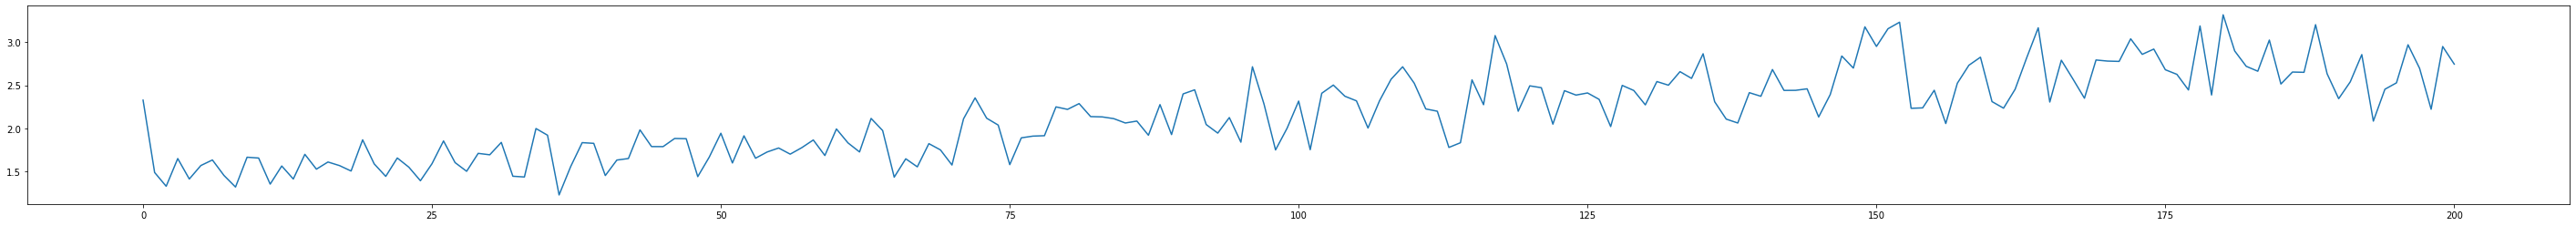

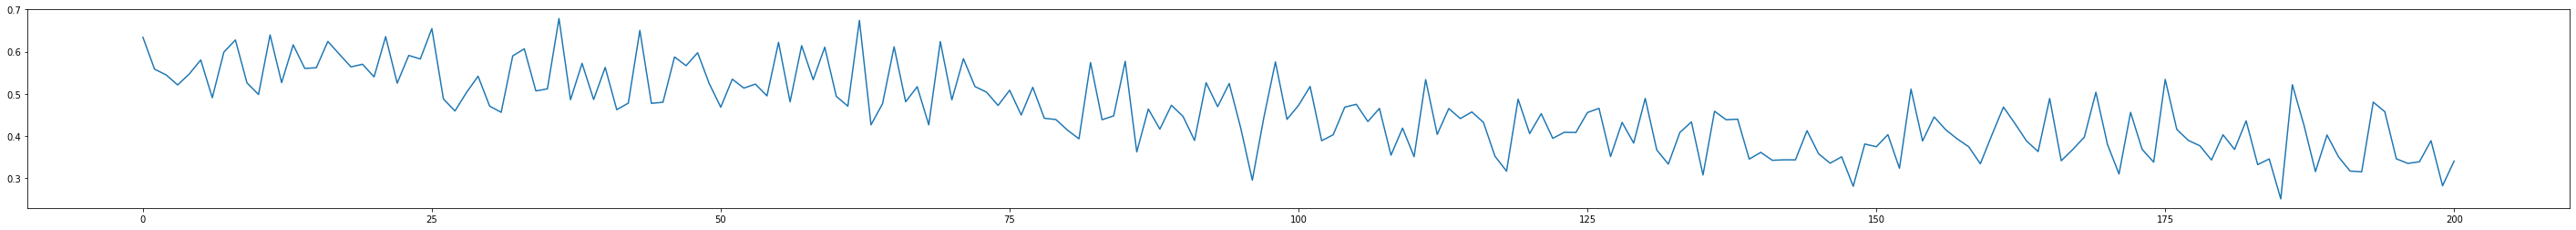

In [22]:
# looking at the loss pattern of generator and discriminator
plt.figure(figsize=(50, 4))
plt.plot(gen_loss);
plt.show()
plt.figure(figsize=(50, 4))
plt.plot(disc_loss);
plt.show()

realdata scores: [[0.87980485]
 [0.9630349 ]
 [0.95464224]
 [0.9510628 ]
 [0.9795196 ]
 [0.9846799 ]
 [0.93181145]
 [0.06819716]
 [0.80017304]
 [0.78650045]]
average: 0.8299427
fakedata scores: [[0.10102782]
 [0.07142323]
 [0.21582904]
 [0.391733  ]
 [0.19009665]
 [0.09609428]
 [0.19366759]
 [0.1971404 ]
 [0.03097783]
 [0.09763192]]
average: 0.15856217


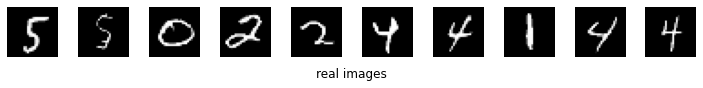

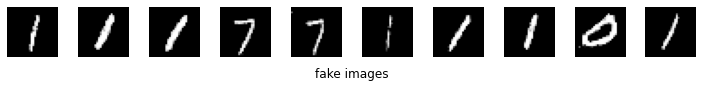

In [26]:
# get random numbers from real dataset and predict
real_data = x_train[np.random.randint(0, x_train.shape[0], 10)]
realdata_scores = discriminator.predict(real_data)
print('realdata scores:', realdata_scores)
print('average:', np.mean(realdata_scores))

noise = np.random.normal(0, 1, size=(10, noise_dim))
fake_data = generator.predict(noise)
fakedata_scores = discriminator.predict(fake_data)
print('fakedata scores:', fakedata_scores)
print('average:', np.mean(fakedata_scores))

plt.figure(figsize=(10, 1))
plt.suptitle('real images', y=0)
for i, image in enumerate(real_data):
    plt.subplot(1, 10, i+1)
    if channels == 1:
        plt.imshow(np.clip(image.reshape((img_rows, img_cols)), 0.0, 1.0), cmap='gray')
    else:
        plt.imshow(np.clip(image.reshape((img_rows, img_cols, channels)), 0.0, 1.0))
    plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 1))
plt.suptitle('fake images', y=0)
for i, image in enumerate(fake_data):
    plt.subplot(1, 10, i+1)
    if channels == 1:
        plt.imshow(np.clip(image.reshape((img_rows, img_cols)), 0.0, 1.0), cmap='gray')
    else:
        plt.imshow(np.clip(image.reshape((img_rows, img_cols, channels)), 0.0, 1.0))
    plt.axis('off')

plt.tight_layout()


In [30]:
# Turn the training process into a GIF
from PIL import Image, ImageDraw

image_names = os.listdir(save_path)
frames = []
for image in sorted(image_names, key=lambda name: int(''.join(i for i in name if i.isdigit()))):
    frames.append(Image.open(save_path + '/' + image))

frames[0].save('gan_training_digits.gif', format='GIF', append_images=frames[1:], save_all=True, duration=500, loop=0)

discriminator.save('dcdiscriminator.hdf5')
generator.save('dcgenerator.hdf5')

In [29]:
image_names

['.ipynb_checkpoints',
 'gan-images_epoch-150.png',
 'gan-images_epoch-125.png',
 'gan-images_epoch-0.png',
 'gan-images_epoch-50.png',
 'gan-images_epoch-175.png',
 'gan-images_epoch-25.png',
 'gan-images_epoch-200.png',
 'gan-images_epoch-100.png',
 'gan-images_epoch-75.png']